# Validation tests for the CLMM backends

This notebook was used to generate the figures of section 3.2.3 of the CLMM v1.0 paper.

In [1]:
import os
os.environ['CLMM_MODELING_BACKEND'] = 'ct'
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
# CLMM with ct be
import clmm
import clmm.theory as m
from clmm import Cosmology as clmm_cosmo

In [3]:
import cluster_toolkit as ct

In [4]:
# NumCosmo
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

In [5]:
# Colossus
from colossus.cosmology import cosmology as col_cosmo
from colossus.halo import profile_nfw
from colossus.halo import profile_einasto
from colossus.halo import profile_hernquist

In [6]:
#CCL
import pyccl as ccl

# Comparison of NFW, Einasto and Hernquist for the various backends

In [7]:
# Colossus Cosmology
cosmo_col = col_cosmo.setCosmology('planck18'); # no massive neutrinos

Omega_c_col = cosmo_col.Om0 - cosmo_col.Ob0
Omega_b_col = cosmo_col.Ob0
h_col       = cosmo_col.H0 / 100.0
n_s_col     = cosmo_col.ns

# CCL Cosmology
cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c_col, Omega_b=Omega_b_col, h=h_col, A_s=2.1e-9, n_s=n_s_col)

# NumCosmo Cosmology
Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm{'massnu-length':<0>}")
cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("H0",        cosmo_col.H0)
cosmo.param_set_by_name ("Omegak",    cosmo_col.Ok(0.0))
cosmo.param_set_by_name ("w",         cosmo_col.w0)
cosmo.param_set_by_name ("Omegab",    Omega_b_col)
cosmo.param_set_by_name ("Omegac",    Omega_c_col)
cosmo.param_set_by_name ("ENnu",      cosmo_col.Neff)
cosmo.param_set_by_name ("Tgamma0",   cosmo_col.Tcmb0)

# CLMM Cosmology: with CT backend, massive neutrinos not taken into account
cosmo_clmm = clmm_cosmo(H0 = cosmo_col.H0, Omega_dm0 = Omega_c_col, Omega_b0 = Omega_b_col, Omega_k0 = 0.0)
print(cosmo_col)

Cosmology "planck18" 
    flat = True, Om0 = 0.3111, Ode0 = 0.6888, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.8102, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [8]:
cosmo_ccl

pyccl.Cosmology(Omega_c=0.2621, Omega_b=0.049, h=0.6766, n_s=0.9665, sigma8=None, A_s=2.1e-09, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, c1_mg=1.0, c2_mg=1.0, lambda_mg=0.0, extra_parameters=None, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='boltzmann_camb', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')

In [9]:
Delta = 200
Mvir  = 1.0e15 # M_sun
cvir  = 5.0
z     = 0.2
a     = 1.0 / (1.0 + z)

# CCL
MDEF               = 'critical'
conc               = ccl.halos.ConcentrationConstant(cvir)
mdef = ccl.halos.MassDef(Delta, 'critical', c_m_relation=conc)
#mdef.concentration = conc

ccl_nfw_num_opt            = ccl.halos.HaloProfileNFW (conc,
                                               truncated = False, 
                                               projected_analytic = False, 
                                               cumul2d_analytic = False,fourier_analytic=False)
ccl_nfw_num            = ccl.halos.HaloProfileNFW (conc,
                                               truncated = False, 
                                               projected_analytic = False, 
                                               cumul2d_analytic = False)
ccl_nfw_ana            = ccl.halos.HaloProfileNFW (conc,
                                               truncated = False, 
                                               projected_analytic = True, 
                                               cumul2d_analytic = True)

#ccl_nfw_num.update_precision_fftlog (n_per_decade = 10000)
#ccl_nfw_num.update_precision_fftlog (plaw_fourier = -2)

ccl_ein            = ccl.halos.HaloProfileEinasto (conc,
                                                   truncated = False)
ccl_her            = ccl.halos.HaloProfileHernquist (conc,
                                                     truncated = False)


alpha = ccl_ein._get_alpha (cosmo_ccl, Mvir, a, mdef)

# Colossus
col_nfw = profile_nfw.NFWProfile (M = (Mvir * cosmo_col.h), c=cvir, z=z, mdef='200c')
col_ein = profile_einasto.EinastoProfile (M = (Mvir * cosmo_col.h), c = cvir, z = z, mdef = '200c', alpha = alpha)
col_her = profile_hernquist.HernquistProfile (M = (Mvir * cosmo_col.h), c = cvir, z = z, mdef = '200c')


In [10]:
# NumCosmo
reltol = 1.0e-8
lnXi   = math.log (1.0e-4)
lnXf   = math.log (1.0e+4)
improve_prec = True

nc_nfw = Nc.HaloDensityProfileNFW.new (Nc.HaloDensityProfileMassDef.CRITICAL, Delta) 
nc_nfw.props.cDelta = cvir
nc_nfw.props.log10MDelta = math.log10(Mvir)

if improve_prec:
    nc_nfw.set_reltol (reltol) 
    nc_nfw.set_lnXi (lnXi)
    nc_nfw.set_lnXf (lnXf)

nc_ein = Nc.HaloDensityProfileEinasto.new (Nc.HaloDensityProfileMassDef.CRITICAL, Delta)
nc_ein.props.cDelta = cvir
nc_ein.props.log10MDelta = math.log10(Mvir)
nc_ein.props.alpha = alpha

if improve_prec:
    nc_ein.set_reltol (reltol) 
    nc_ein.set_lnXi (lnXi)
    nc_ein.set_lnXf (lnXf)

nc_her = Nc.HaloDensityProfileHernquist.new (Nc.HaloDensityProfileMassDef.CRITICAL, Delta)
nc_her.props.cDelta = cvir
nc_her.props.log10MDelta = math.log10(Mvir)

if improve_prec:
    nc_her.set_reltol (reltol) 
    nc_her.set_lnXi (lnXi)
    nc_her.set_lnXf (lnXf)

smd = Nc.WLSurfaceMassDensity.new (Nc.Distance.new (5.0))
smd.prepare (cosmo)

In [11]:
r     = 10**np.arange (0, +4, 0.02) * 1.0e-3 # Mpc - physical
#r = np.geomspace(1.e-3, 10, 400)

## Sigma

In [12]:
rho_m = cosmo_col.rho_m (z) * (cosmo.h2 () * 1.0e9) # matter density units: M_sun / Mpc^3

# Colossus
col_Sigma_nfw = col_nfw.surfaceDensity (r * cosmo_col.h * 1.0e3) * (cosmo.h () * 1.0e6)
col_Sigma_ein = col_ein.surfaceDensity (r * cosmo_col.h * 1.0e3) * (cosmo.h () * 1.0e6)
col_Sigma_her = col_her.surfaceDensity (r * cosmo_col.h * 1.0e3) * (cosmo.h () * 1.0e6)

# NumCosmo
# Analytical
nc_Sigma_nfw_ana  = smd.sigma_array (nc_nfw, cosmo, r, 1.0, 1.0, z)
# Numerical 
Nc.halo_density_profile_nfw_class_set_ni (True)
nc_Sigma_nfw_num  = smd.sigma_array (nc_nfw, cosmo, r, 1.0, 1.0, z)
Nc.halo_density_profile_nfw_class_set_ni (False)
nc_Sigma_ein  = smd.sigma_array (nc_ein, cosmo, r, 1.0, 1.0, z)
nc_Sigma_her  = smd.sigma_array (nc_her, cosmo, r, 1.0, 1.0, z)

# CCL
ccl_Sigma_nfw_ana = ccl_nfw_ana.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_Sigma_nfw_num = ccl_nfw_num.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_Sigma_ein = ccl_ein.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_Sigma_her = ccl_her.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2


# CCL numerical NFW, using optimised setup
# When using fourier_analytic=False in CCL profile definition, CCL performs
# better by first evaluating the profile on a wider range and then 
# interpolating to the desired radii
rtmp = np.geomspace(1.e-4, 100, 1000)
tmp = ccl_nfw_num_opt.projected (cosmo_ccl, rtmp/a, Mvir, a, mdef)/ a**2
ptf = interp1d(np.log(rtmp), np.log(tmp), bounds_error=False, fill_value=-100)
ccl_Sigma_nfw_num_opt = np.exp(ptf(np.log(r)))

tmp = ccl_ein.projected (cosmo_ccl, rtmp/a, Mvir, a, mdef)/ a**2
ptf = interp1d(np.log(rtmp), np.log(tmp), bounds_error=False, fill_value=-100)
ccl_Sigma_ein_opt = np.exp(ptf(np.log(r)))

tmp = ccl_her.projected (cosmo_ccl, rtmp/a, Mvir, a, mdef)/ a**2
ptf = interp1d(np.log(rtmp), np.log(tmp), bounds_error=False, fill_value=-100)
ccl_Sigma_her_opt = np.exp(ptf(np.log(r)))

# CT NFW through CLMM (analytical)
ct_Sigma_nfw = m.compute_surface_density(r, Mvir, cvir, z, cosmo=cosmo_clmm, massdef='critical', 
                                         delta_mdef=Delta, halo_profile_model= 'nfw')



## DeltaSigma

In [13]:
# Colossus
col_DeltaSigma_nfw = col_nfw.deltaSigma(r * cosmo_col.h * 1.0e3) * (cosmo.h () * 1.0e6)
col_DeltaSigma_ein = col_ein.deltaSigma (r * cosmo_col.h * 1.0e3) * (cosmo.h () * 1.0e6)
col_DeltaSigma_her = col_her.deltaSigma (r * cosmo_col.h * 1.0e3) * (cosmo.h () * 1.0e6)

# NumCosmo
# Analytical
nc_DeltaSigma_nfw_ana = np.array (smd.sigma_excess_array (nc_nfw, cosmo, r, 1.0, 1.0, z))
# Numerical
Nc.halo_density_profile_nfw_class_set_ni (True)
nc_DeltaSigma_nfw_num = np.array (smd.sigma_excess_array (nc_nfw, cosmo, r, 1.0, 1.0, z))
Nc.halo_density_profile_nfw_class_set_ni (False)
nc_DeltaSigma_ein  = np.array (smd.sigma_excess_array (nc_ein, cosmo, r, 1.0, 1.0, z))
nc_DeltaSigma_her  = np.array (smd.sigma_excess_array (nc_her, cosmo, r, 1.0, 1.0, z))

# CCL
ccl_BarSigma_nfw_ana = ccl_nfw_ana.cumul2d (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_DeltaSigma_nfw_ana = ccl_BarSigma_nfw_ana - ccl_Sigma_nfw_ana

# CCL numerical NFW, using default setup
ccl_BarSigma_nfw_num = ccl_nfw_num.cumul2d (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_DeltaSigma_nfw_num = ccl_BarSigma_nfw_num - ccl_Sigma_nfw_num
ccl_BarSigma_ein = ccl_ein.cumul2d (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_DeltaSigma_ein = ccl_BarSigma_ein - ccl_Sigma_ein
ccl_BarSigma_her = ccl_her.cumul2d (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_DeltaSigma_her = ccl_BarSigma_her - ccl_Sigma_her


# CCL numerical NFW, using optimised setup
# When using fourier_analytic=False in CCL profile definition, CCL performs
# better by first evaluating the profile on a wider range and then 
# interpolating to the desired radii

rtmp = np.geomspace(1.e-4, 100, 1000) # extended radial range
tmp = ccl_nfw_num_opt.cumul2d (cosmo_ccl, rtmp / a, Mvir, a, mdef) / a**2 # CCL estimation
ptf = interp1d(np.log(rtmp), np.log(tmp), bounds_error=False, fill_value=-100) # interpolation
ccl_BarSigma_nfw_num_opt = np.exp(ptf(np.log(r))) # evaluation on the desired radius array
ccl_DeltaSigma_nfw_num_opt = ccl_BarSigma_nfw_num_opt - ccl_Sigma_nfw_num_opt

tmp = ccl_ein.cumul2d (cosmo_ccl, rtmp/a, Mvir, a, mdef)/ a**2
ptf = interp1d(np.log(rtmp), np.log(tmp), bounds_error=False, fill_value=-100)
ccl_BarSigma_ein_opt = np.exp(ptf(np.log(r)))
ccl_DeltaSigma_ein_opt = ccl_BarSigma_ein_opt - ccl_Sigma_ein_opt

tmp = ccl_her.cumul2d (cosmo_ccl, rtmp/a, Mvir, a, mdef)/ a**2
ptf = interp1d(np.log(rtmp), np.log(tmp), bounds_error=False, fill_value=-100)
ccl_BarSigma_her_opt = np.exp(ptf(np.log(r)))
ccl_DeltaSigma_her_opt = ccl_BarSigma_her_opt - ccl_Sigma_her_opt

# CT NFW through CLMM (analytical)
ct_DeltaSigma_nfw = m.compute_excess_surface_density(r, Mvir, cvir, z, cosmo=cosmo_clmm, 
                                  delta_mdef=Delta, massdef='critical',
                                  halo_profile_model='nfw')

In [14]:
#np.savetxt("NC_einasto.txt", np.vstack((r,nc_Sigma_ein,nc_DeltaSigma_ein)).T)
#np.savetxt("NC_hernquist.txt", np.vstack((r,nc_Sigma_her,nc_DeltaSigma_her)).T)


## Special treatment for CT (numerical NFW and Einasto)

In [15]:
E2_ccl = cosmo_ccl.h_over_h0(a)**2
E2_ct = (cosmo_clmm.be_cosmo.H(z)/cosmo_clmm.be_cosmo.H0)**2
Om_ccl = cosmo_ccl.omega_x(a, 'matter')
Om_ct = cosmo_clmm.be_cosmo.Om(z)
E2Om_ccl = E2_ccl*Om_ccl
E2Om_ct = E2_ct*Om_ct

In [16]:
print(E2_ct/E2_ccl-1)
print(Om_ct/Om_ccl-1)
print(E2Om_ct/E2Om_ccl-1)

0.0008289601791924284
-0.0008282369326557681
3.667110060057155e-08


In [17]:
from clmm.constants import Constants as const

cor_factor = clmm.utils._patch_rho_crit_to_cd2018(2.77533742639e+11)
omega_m = E2_ct*cor_factor

rhocrit_mks = 3.*100.*100./(8.*np.pi*const.GNEWT.value)
rhocrit_cosmo = rhocrit_mks * 1000. * 1000. * const.PC_TO_METER.value * 1.e6 / const.SOLAR_MASS.value

# Need to defined the 3d density and the tabulated sigma profile on a wide enough range
r_for_sigma = np.logspace(-6,2, len(r)*1000)
r3d = np.logspace(-7,3, len(r)*1000)

# CT NFW through CT (numerical)
rho_nfw = ct.density.rho_nfw_at_r(r3d*cosmo_clmm['h'], Mvir*cosmo_clmm['h'], cvir, omega_m, delta=Delta)
integrand_nfw = rho_nfw/(omega_m*rhocrit_cosmo) # xi_nfw + 1 (see CT documentation)

ct_Sigma_nfw_num = ct.deltasigma.Sigma_at_R(r*cosmo_clmm['h'], r3d*cosmo_clmm['h'], integrand_nfw, 
                                        Mvir*cosmo_clmm['h'], cvir, omega_m)*cosmo_clmm['h']*1.0e12 # Msun/Mpc2

# Redefine Sigma on finer grid for the numerical integration for DeltaSigma
tmp_nfw = ct.deltasigma.Sigma_at_R(r_for_sigma*cosmo_clmm['h'], r3d*cosmo_clmm['h'], integrand_nfw, 
                                        Mvir*cosmo_clmm['h'], cvir, omega_m)*cosmo_clmm['h']*1.0e12 # Msun/Mpc2
ct_DeltaSigma_nfw_num = ct.deltasigma.DeltaSigma_at_R(r*cosmo_clmm['h'], r_for_sigma*cosmo_clmm['h'], tmp_nfw, 
                                                  Mvir*cosmo_clmm['h'], cvir, omega_m)

# CT Einasto through CT
rho_einasto = ct.density.rho_einasto_at_r(r3d*cosmo_clmm['h'], Mvir*cosmo_clmm['h'], cvir, alpha, omega_m, delta=Delta)
integrand = rho_einasto/(omega_m*rhocrit_cosmo) # xi_einasto + 1 (see CT documentation)

ct_Sigma_ein = ct.deltasigma.Sigma_at_R(r*cosmo_clmm['h'], r3d*cosmo_clmm['h'], integrand, 
                                        Mvir*cosmo_clmm['h'], cvir, omega_m)*cosmo_clmm['h']*1.0e12 # Msun/Mpc2


# Redefine Sigma on finer grid for the numerical integration for DeltaSigma
tmp = ct.deltasigma.Sigma_at_R(r_for_sigma*cosmo_clmm['h'], r3d*cosmo_clmm['h'], integrand, 
                                        Mvir*cosmo_clmm['h'], cvir, omega_m)*cosmo_clmm['h']*1.0e12 # Msun/Mpc2
ct_DeltaSigma_ein = ct.deltasigma.DeltaSigma_at_R(r*cosmo_clmm['h'], r_for_sigma*cosmo_clmm['h'], tmp, 
                                                  Mvir*cosmo_clmm['h'], cvir, omega_m)

## NFW: compare NC (analytical and numerical), CCL (numerical), CT (analytical and numerical) to analytical CCL

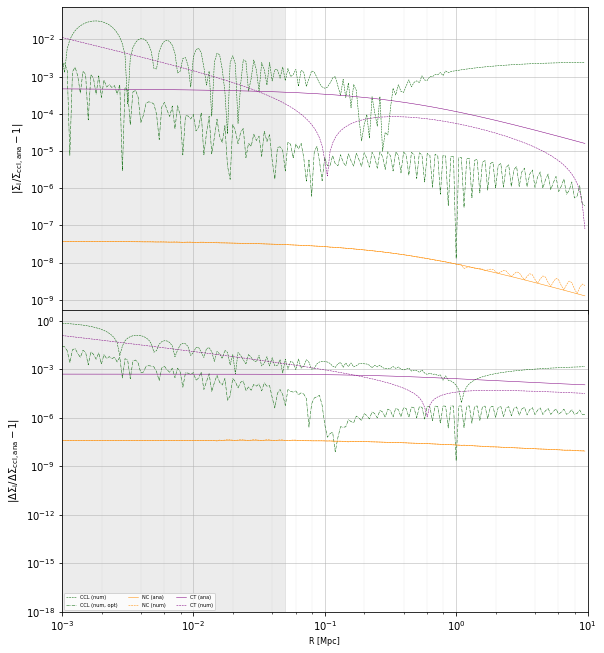

In [18]:
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0},
                         figsize=(10, 10))

axs[0].plot (r, np.abs (ccl_Sigma_nfw_num / ccl_Sigma_nfw_ana - 1.0), 
             label = "CCL (num)", linestyle='--', color='darkgreen', lw=0.5)
axs[0].plot (r, np.abs (ccl_Sigma_nfw_num_opt / ccl_Sigma_nfw_ana - 1.0), 
             label = "CCL (num, opt)", linestyle='-.', color='darkgreen', lw=0.5)
axs[0].plot (r, np.abs (nc_Sigma_nfw_ana / ccl_Sigma_nfw_ana - 1.0), 
             label = "NC (ana)", linestyle='-', color='darkorange', lw=0.5)
axs[0].plot (r, np.abs (nc_Sigma_nfw_num / ccl_Sigma_nfw_ana - 1.0), 
             label = "NC (num)", linestyle='--', color='darkorange', lw=0.5)
axs[0].plot (r, np.abs (ct_Sigma_nfw / ccl_Sigma_nfw_ana - 1.0), 
             label = "CT (ana)", linestyle='-', color='purple', lw=0.5)
axs[0].plot (r, np.abs (ct_Sigma_nfw_num / ccl_Sigma_nfw_ana - 1.0), 
             label = "CT (num)", linestyle='--', color='purple', lw=0.5)

axs[1].plot (r, np.abs (ccl_DeltaSigma_nfw_num / ccl_DeltaSigma_nfw_ana - 1.0), 
             label = "CCL (num)", linestyle='--', color='darkgreen', lw=0.5)
axs[1].plot (r, np.abs (ccl_DeltaSigma_nfw_num_opt / ccl_DeltaSigma_nfw_ana - 1.0), 
             label = "CCL (num, opt)", linestyle='-.', color='darkgreen', lw=0.5)
axs[1].plot (r, np.abs (nc_DeltaSigma_nfw_ana / ccl_DeltaSigma_nfw_ana - 1.0), 
             label = "NC (ana)", linestyle='-', color='darkorange', lw=0.5)
axs[1].plot (r, np.abs (nc_DeltaSigma_nfw_num / ccl_DeltaSigma_nfw_ana - 1.0), 
             label = "NC (num)", linestyle='--', color='darkorange', lw=0.5)
axs[1].plot (r, np.abs (ct_DeltaSigma_nfw / ccl_DeltaSigma_nfw_ana - 1.0), 
             label = "CT (ana)", linestyle='-', color='purple', lw=0.5)
axs[1].plot (r, np.abs (ct_DeltaSigma_nfw_num / ccl_DeltaSigma_nfw_ana - 1.0), 
             label = "CT (num)", linestyle='--', color='purple', lw=0.5)


#axs[0].set_ylim([1.e-14,1.e0])
# axs[0].set_xlim([5.e-5,100])
axs[1].set_xlabel('R [Mpc]', fontsize=8)
axs[0].set_ylabel(r'$|\Sigma_{\mathrm{i}} / \Sigma_{\mathrm{ccl, ana}} - 1|$', fontsize=10)
axs[1].set_ylabel(r'$|\Delta\Sigma_{\mathrm{i}} / \Delta\Sigma_{\mathrm{ccl, ana}} - 1|$', fontsize=10)
axs[1].set_ylim([1.e-18, 5.e0])
axs[0].set_xlim([1.e-3, 1.e1])
axs[1].set_xlim([1.e-3, 1.e1])
# axs[0].legend(fontsize=5, loc='center left',
#               bbox_to_anchor=(0.,0.55), ncol=2)
axs[1].legend(fontsize=5, loc='lower left', ncol=3)
fig.tight_layout()

axs[0].axvspan(1.e-3, 5.e-2, alpha=0.15, color='gray')
axs[1].axvspan(1.e-3, 5.e-2, alpha=0.15, color='gray')

for ax in axs:
    ax.set_xscale ('log')
    ax.set_yscale ('log')    
    ax.xaxis.grid(True, which='major', lw=.5)
    ax.yaxis.grid(True, which='major', lw=.5)
    ax.xaxis.grid(True, which='minor', lw=.1)
    ax.yaxis.grid(True, which='minor', lw=.1)
    ax.set_xticks(np.logspace(-3 ,1 ,5))
    ax.xaxis.set_minor_locator(LogLocator(
        base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=12))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_minor_locator(LogLocator(
        base=10.0, subs=(1,10,100), numticks=12))
    ax.yaxis.set_minor_formatter(NullFormatter())

    
plt.subplots_adjust(left=.22, right=0.95, bottom=.15, top=.99)
#fig.savefig('NFW_precision.pdf')
#fig.savefig('NFW_precision.png', dpi=300)

# Compare all to Colossus

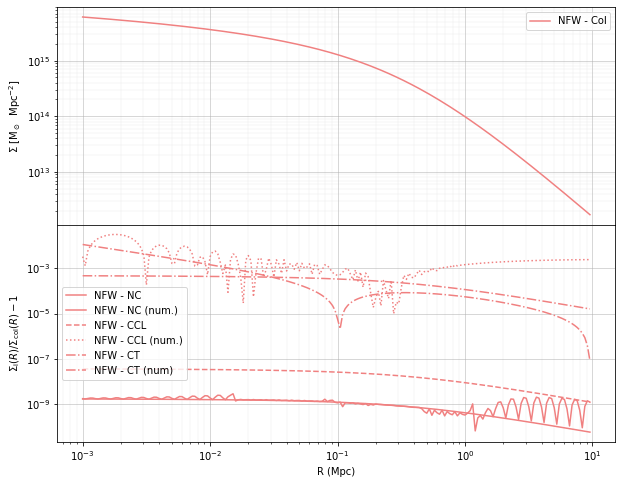

In [19]:
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(10,8))

axs[1].set_xlabel('R (Mpc)')
axs[0].set_ylabel(r'$\Sigma$ [M$_\odot$  Mpc$^{-2}$]')
axs[1].set_ylabel(r'$\Sigma_{\mathrm{i}} (R) / \Sigma_{\mathrm{col}} (R) - 1$')
axs[0].plot (r, col_Sigma_nfw, '-', label = 'NFW - Col', color = 'lightcoral')
#axs[0].plot (r, col_Sigma_ein, '-', label = 'EIN - Col', color = 'cadetblue')
#axs[0].plot (r, col_Sigma_her, '-', label = 'HER - Col', color = 'tan')

axs[1].plot (r, np.abs (nc_Sigma_nfw_ana / col_Sigma_nfw - 1.0), label = "NFW - NC", linestyle='-', color='lightcoral')
axs[1].plot (r, np.abs (nc_Sigma_nfw_num / col_Sigma_nfw - 1.0), label = "NFW - NC (num.)", linestyle='-', color='lightcoral')
axs[1].plot (r, np.abs (ccl_Sigma_nfw_ana / col_Sigma_nfw - 1.0), label = "NFW - CCL", linestyle='--', color='lightcoral')
axs[1].plot (r, np.abs (ccl_Sigma_nfw_num / col_Sigma_nfw - 1.0), label = "NFW - CCL (num.)", linestyle=':', color='lightcoral')
axs[1].plot (r, np.abs (ct_Sigma_nfw / col_Sigma_nfw - 1.0), label = "NFW - CT", linestyle='-.', color='lightcoral')
axs[1].plot (r, np.abs (ct_Sigma_nfw_num / col_Sigma_nfw - 1.0),  label = "NFW - CT (num)", linestyle='-.', color='lightcoral')
#axs[1].plot (r, np.abs (nc_Sigma_ein / col_Sigma_ein - 1.0), label = "EIN - NC", color='cadetblue', linestyle='-')
#axs[1].plot (r, np.abs (ccl_Sigma_ein / col_Sigma_ein - 1.0), label = "EIN - CCL", color='cadetblue', linestyle='--')
#axs[1].plot (r, np.abs (ct_Sigma_ein / col_Sigma_ein - 1.0), label = "EIN - CT", color='cadetblue', linestyle='-.')
#axs[1].plot (r, np.abs (nc_Sigma_her / col_Sigma_her - 1.0), label = "HER - NC", color='tan', linestyle='-')
#axs[1].plot (r, np.abs (ccl_Sigma_her / col_Sigma_her - 1.0), label = "HER - CCL", color='tan', linestyle='--')

axs[0].legend(loc='best')
axs[1].legend(loc='best')

for ax in axs:
    ax.set_xscale ('log')
    ax.set_yscale ('log')
    ax.xaxis.grid(True, which='major', lw=.5)
    ax.yaxis.grid(True, which='major', lw=.5)
    ax.xaxis.grid(True, which='minor', lw=.1)
    ax.yaxis.grid(True, which='minor', lw=.1)
#fig.savefig('Sigma_precision.pdf')

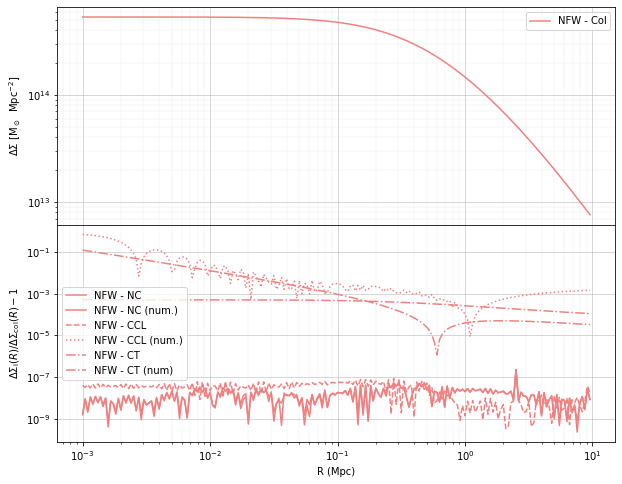

In [20]:
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(10,8))

axs[1].set_xlabel('R (Mpc)')
axs[0].set_ylabel(r'$\Delta\Sigma$ [M$_\odot$  Mpc$^{-2}$]')
axs[1].set_ylabel(r'$\Delta\Sigma_{\mathrm{i}} (R) / \Delta\Sigma_{\mathrm{col}} (R) - 1$')
axs[0].plot (r, col_DeltaSigma_nfw, '-', label = 'NFW - Col', color = 'lightcoral')
#axs[0].plot (r, col_DeltaSigma_ein, '-', label = 'EIN - Col', color = 'cadetblue')
#axs[0].plot (r, col_DeltaSigma_her, '-', label = 'HER - Col', color = 'tan')
axs[1].plot (r, np.abs (nc_DeltaSigma_nfw_ana / col_DeltaSigma_nfw - 1.0), label = "NFW - NC", linestyle='-', color='lightcoral')
axs[1].plot (r, np.abs (nc_DeltaSigma_nfw_num / col_DeltaSigma_nfw - 1.0), label = "NFW - NC (num.)", linestyle='-', color='lightcoral')
axs[1].plot (r, np.abs (ccl_DeltaSigma_nfw_ana / col_DeltaSigma_nfw - 1.0), label = "NFW - CCL", linestyle='--', color='lightcoral')
axs[1].plot (r, np.abs (ccl_DeltaSigma_nfw_num / col_DeltaSigma_nfw - 1.0), label = "NFW - CCL (num.)", linestyle=':', color='lightcoral')
axs[1].plot (r, np.abs (ct_DeltaSigma_nfw / col_DeltaSigma_nfw - 1.0), label = "NFW - CT", linestyle='-.', color='lightcoral')
axs[1].plot (r, np.abs (ct_DeltaSigma_nfw_num / col_DeltaSigma_nfw - 1.0), label = "NFW - CT (num)", linestyle='-.', color='lightcoral')
#axs[1].plot (r, np.abs (nc_DeltaSigma_ein / col_DeltaSigma_ein - 1.0), label = "EIN - NC", linestyle='-', color='cadetblue')
#axs[1].plot (r, np.abs (ccl_DeltaSigma_ein / col_DeltaSigma_ein - 1.0), label = "EIN - CCL", linestyle='--', color='cadetblue')
#axs[1].plot (r, np.abs (ct_DeltaSigma_ein / col_DeltaSigma_ein - 1.0), label = "EIN - CT", linestyle='-.', color='cadetblue')
#axs[1].plot (r, np.abs (nc_DeltaSigma_her / col_DeltaSigma_her - 1.0), label = "HER - NC", linestyle='-', color='tan')
#axs[1].plot (r, np.abs (ccl_DeltaSigma_her / col_DeltaSigma_her - 1.0), label = "HER - CCL", linestyle='--', color='tan')

axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[1].grid()
for ax in axs:
    ax.set_xscale ('log')
    ax.set_yscale ('log')
    ax.xaxis.grid(True, which='major', lw=.5)
    ax.yaxis.grid(True, which='major', lw=.5)
    ax.xaxis.grid(True, which='minor', lw=.1)
    ax.yaxis.grid(True, which='minor', lw=.1)

#fig.savefig('DeltaSigma_precision.pdf')